In [ ]:
import os
import numpy as np
from PIL import Image

# Veri seti yolu
data_path = "/content/drive/MyDrive/malaria/cell_images/cell_images"

# Sınıf etiketleri
class_names = ["Parasitized", "Uninfected"]

# Veri setindeki görüntü sayısı
num_samples = sum([len(files) for r, d, files in os.walk(data_path)])

# Veri seti boyutları
img_height, img_width = 64, 64
num_channels = 3

# X ve y için numpy dizileri
X = np.zeros((num_samples, img_height, img_width, num_channels), dtype=np.float32)
y = np.zeros((num_samples,), dtype=np.int32)

# Verileri yükleyip numpy dizilerine dönüştürme
index = 0
for i, class_name in enumerate(class_names):
    class_path = os.path.join(data_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        img = img.resize((img_height, img_width))
        X[index] = np.array(img, dtype=np.float32) / 255.
        y[index] = i
        index += 1

# Veri setini karıştırma
np.random.seed(42)
shuffle_index = np.random.permutation(num_samples)
X, y = X[shuffle_index], y[shuffle_index]

# Veri setini train, test ve validation olarak ayırma
num_train_samples = int(0.7 * num_samples)
num_test_samples = int(0.2 * num_samples)
num_val_samples = num_samples - num_train_samples - num_test_samples

x_train, y_train = X[:num_train_samples], y[:num_train_samples]
x_test, y_test = X[num_train_samples:num_train_samples+num_test_samples], y[num_train_samples:num_train_samples+num_test_samples]
x_val, y_val = X[num_train_samples+num_test_samples:], y[num_train_samples+num_test_samples:]

# Dizileri npy dosyalarına kaydetme
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)
np.save('x_val.npy', x_val)
np.save('y_val.npy', y_val)


In [ ]:
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [ ]:
# Dizileri yükleme
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')
x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')

In [ ]:
# CNN Modelini Oluşturma
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, num_channels)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))  # Dropout katmanını ekledik
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# CNN Modelini eğitme
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/100
603/603 [==============================] - 16s 7ms/step - loss: 0.4191 - accuracy: 0.8114 - val_loss: 0.2132 - val_accuracy: 0.9238
Epoch 2/100
603/603 [==============================] - 5s 8ms/step - loss: 0.1978 - accuracy: 0.9263 - val_loss: 0.1957 - val_accuracy: 0.9213
Epoch 3/100
603/603 [==============================] - 4s 7ms/step - loss: 0.1630 - accuracy: 0.9432 - val_loss: 0.1640 - val_accuracy: 0.9470
Epoch 4/100
603/603 [==============================] - 4s 6ms/step - loss: 0.1431 - accuracy: 0.9523 - val_loss: 0.1462 - val_accuracy: 0.9518
Epoch 5/100
603/603 [==============================] - 4s 7ms/step - loss: 0.1244 - accuracy: 0.9569 - val_loss: 0.1507 - val_accuracy: 0.9496
Epoch 6/100
603/603 [==============================] - 4s 7ms/step - loss: 0.1072 - accuracy: 0.9623 - val_loss: 0.1479 - val_accuracy: 0.9485
Epoch 7/100
603/603 [==============================] - 4s 6ms/step - loss: 0.0901 - accuracy: 0.9682 - val_loss: 0.1760 - val_accuracy: 0.948

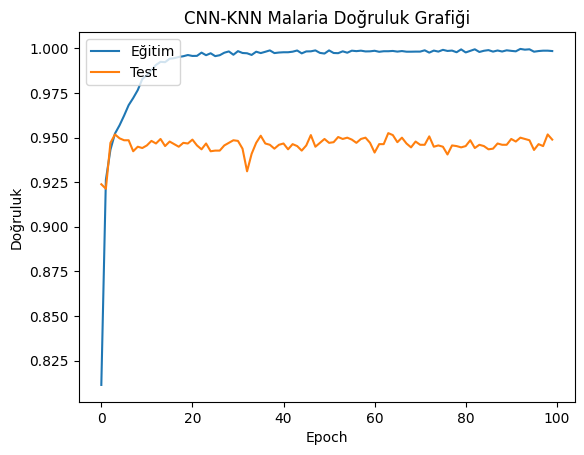

In [ ]:
# Accuracy grafiği
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN-KNN Malaria Doğruluk Grafiği')
plt.ylabel('Doğruluk')
plt.xlabel('Epoch')
plt.legend(['Eğitim', 'Test'], loc='upper left')
plt.show()

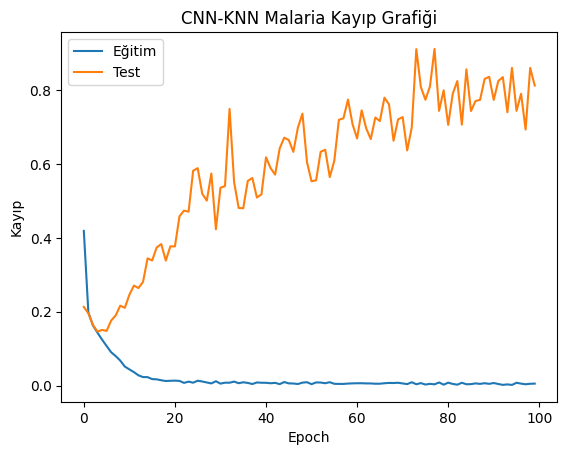

In [ ]:
# Loss grafiği
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN-KNN Malaria Kayıp Grafiği')
plt.ylabel('Kayıp')
plt.xlabel('Epoch')
plt.legend(['Eğitim', 'Test'], loc='upper left')
plt.show()

In [ ]:
# CNN'nin özelliklerini çıkarın
train_features = cnn_model.predict(x_train)
test_features = cnn_model.predict(x_test)

173/173 [==============================] - 1s 4ms/step


In [ ]:
# KNN Modelini Oluşturma ve eğitme
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_features, y_train)

KNeighborsClassifier()

In [ ]:
# KNN ile tahmin yapma
knn_predictions = knn_model.predict(test_features)

In [ ]:
# Hibrit modelin performansını değerlendirme
train_predictions = knn_model.predict(train_features)
test_predictions = knn_model.predict(test_features)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print("Eğitim verisi doğruluğu:", train_accuracy)
print("Test verisi doğruluğu:", test_accuracy)


Eğitim verisi doğruluğu: 1.0
Test verisi doğruluğu: 0.949918345127926


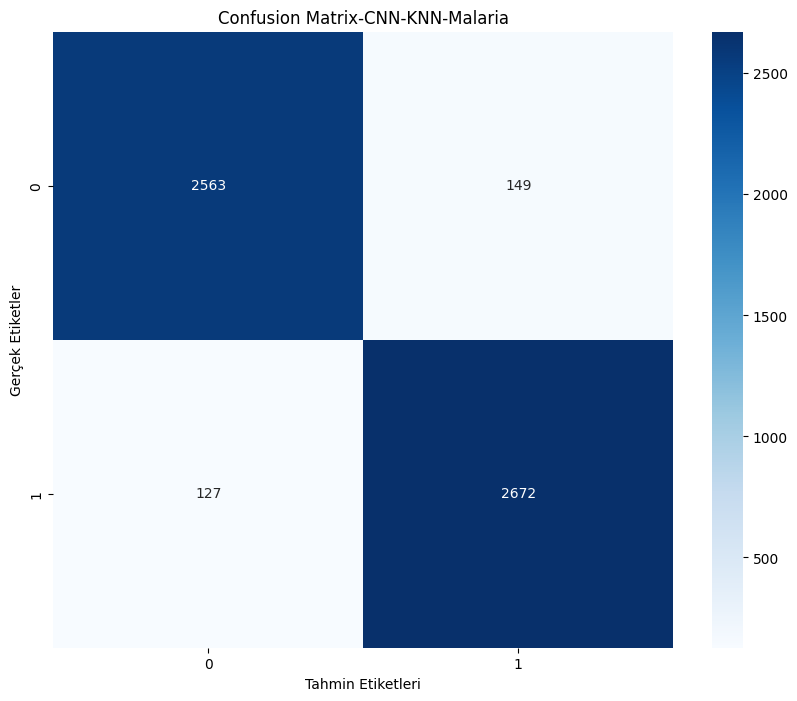

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, knn_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix-CNN-KNN-Malaria')
plt.xlabel('Tahmin Etiketleri')
plt.ylabel('Gerçek Etiketler')
plt.show()

In [ ]:
# Sınıflandırma raporu
classification_rep = classification_report(y_test, knn_predictions)
print('Sınıflandırma Raporu:\n', classification_rep)

# Recall, precision ve f1-score değerlerini elde etme
report_lines = classification_rep.split('\n')
for line in report_lines[2:-5]:
    line_data = line.split()
    if len(line_data) >= 4:
        class_label = int(line_data[0])
        precision = float(line_data[1])
        recall = float(line_data[2])
        f1 = float(line_data[3])
        print('Sınıf:', class_label)
        print('Precision:', precision)
        print('Recall:', recall)
        print('F1-score:', f1)
        print('----------------------')

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      2712
           1       0.95      0.95      0.95      2799

    accuracy                           0.95      5511
   macro avg       0.95      0.95      0.95      5511
weighted avg       0.95      0.95      0.95      5511

Sınıf: 0
Precision: 0.95
Recall: 0.95
F1-score: 0.95
----------------------
Sınıf: 1
Precision: 0.95
Recall: 0.95
F1-score: 0.95
----------------------


In [ ]:
# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=[0, 1])

# Binarize the KNN predictions
knn_predictions_bin = label_binarize(knn_predictions, classes=[0, 1])

# Makro ve mikro AUC skorlarını hesaplama
macro_auc = roc_auc_score(y_test_bin, knn_predictions_bin, average='macro')
micro_auc = roc_auc_score(y_test_bin, knn_predictions_bin, average='micro')
print("Makro AUC skoru:", macro_auc)
print("Mikro AUC skoru:", micro_auc)


Makro AUC skoru: 0.9498428247129981
Mikro AUC skoru: 0.9498428247129981


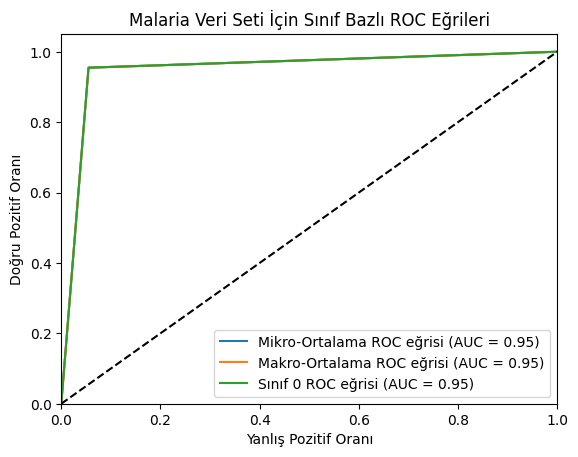

In [ ]:
# ROC eğrilerini elde etme
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), knn_predictions_bin.ravel())
fpr_macro, tpr_macro, _ = roc_curve(y_test_bin.ravel(), knn_predictions_bin.ravel(), pos_label=1)

# Sınıf bazlı ROC eğrilerini elde etme
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], knn_predictions_bin[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], knn_predictions_bin[:, i])

# ROC eğrilerini çizdirme
plt.figure()
plt.plot(fpr_micro, tpr_micro, label='Mikro-Ortalama ROC eğrisi (AUC = %0.2f)' % micro_auc)
plt.plot(fpr_macro, tpr_macro, label='Makro-Ortalama ROC eğrisi (AUC = %0.2f)' % macro_auc)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Sınıf %d ROC eğrisi (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.title('Malaria Veri Seti İçin Sınıf Bazlı ROC Eğrileri')
plt.legend(loc="lower right")
plt.show()